# Terrain Fourier Analysis

version 1.0: Jun 3, 2021

## Plot 1D periodograms (pgrams)
- reads in a file with 1 or more profiles
- detrends profiles (can show trend lines and/or residuals after detrending)
- calculates a peridogram and significance line for each profiles (significance level can be set)
- plots the averaged pgrams, avg. significance line, red-noise baseline and individual pgrams
- Run the next cell, then go to __Load data__

In [1]:
import pandas as pd
import numpy as np
from TerrainFourierAnalysis_module import *

### Load Data
- Loads 1+ profiles from a text file with tab separated columns and no header line. 
- Each profile must have separate x (distance) and y (elevation) columns

5 profile example:
```
0               64.2998 0               63.8633	0               63.864  0               63.711	0               64.1124
0.999687563	64.336	0.999687563	63.904	0.999687563	63.8535	0.999687563	63.7444	0.999687566	64.2229
1.999375129	64.369	1.999375129	63.9143	1.999375126	63.8981	1.999375129	63.7835	1.999375132	64.2584
2.999062695	64.4413	2.999062692	63.9169	2.999062692	63.9228	2.999062692	63.8436	2.999062695	64.3006
3.998750255	64.4648	3.998750255	63.9522	3.998750252	63.9994	3.998750255	63.8869	3.998750255	64.3307
4.998437819	64.494	4.998437819	63.9989	4.998437816	64.0661	4.998437822	63.9529	4.998437821	64.4011
```

In [2]:
filename = 'S09_5p.txt'

# read in tab separated txt file, no header
df = pd.read_csv(filename, sep="\t", header=None) # tab separated txt file
print(filename, ":", len(df), "samples,", len(list(df)) // 2, "profiles")
ar2D = df.to_numpy()

# put x and y columns into lists 
x_lst, y_lst = get_profiles(ar2D)

# show array as dataframe (nicer!)
pd.DataFrame(ar2D)

S09_5p.txt : 2193 samples, 5 profiles


,0,1,2,3,4,5,6,7,8,9
0,0.000000,45.8051,0.000000,44.3079,0.000000,46.5567,0.000000,43.3852,0.000000,45.8522
1,0.999646,45.9988,0.999646,44.3802,0.999646,46.8987,0.999646,43.4725,0.999646,46.0860
2,1.999293,46.2920,1.999293,44.3912,1.999293,47.1472,1.999293,43.6379,1.999293,46.3454
3,2.998939,46.5865,2.998939,44.4444,2.998939,47.2781,2.998939,43.8029,2.998939,46.6047
4,3.998586,46.8623,3.998586,44.5189,3.998586,47.5032,3.998586,43.9320,3.998586,46.8179
...,...,...,...,...,...,...,...,...,...,...
2188,2187.226277,66.8379,2187.226277,66.5647,2187.226277,67.1029,2187.226277,66.9948,2187.226277,67.0410
2189,2188.225923,66.7792,2188.225923,66.5472,2188.225923,67.1043,2188.225923,67.1742,2188.225923,66.9538
2190,2189.225569,66.7171,2189.225569,66.5310,2189.225569,67.1494,2189.225569,67.3303,2189.225569,66.8676
2191,2190.225216,66.7329,2190.225216,66.4965,2190.225216,67.1910,2190.225216,67.4061,2190.225216,66.8523


### Plot trends to establish trend order for later removal
- You will need to decide on a trend order to be removed later. 
- You can experiement with several trend orders first (e.g. first, second and third order) and decide on a "best" trend, by looking a the variances
- Put each trend you want to be plotted in the list below, order must be 1 or bigger.
- E.g.: `trend_list = [1, 2, 3]` will plot first, second and third order trends through the averaged profile (x/y)
- You will also see how much variance each trend captures of the profile, this should be around 80% or more
- Note: high order trends (4,5,6, etc.) will always have higher percentages, however, they will lead to overfitting. Typically orders 2 or 3 are high enough!
- Hover over the upper left corner of the plot to go into interactive mode, where you can zoom in and save the plot to file

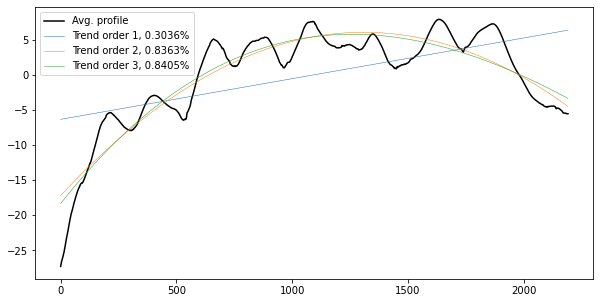

In [3]:
# plot trends
x, y = avg_amplitude(ar2D) # averages profiles into a single profile
trend_list = [1, 2, 3] 
plot_trends(x, y, trend_list, filename);

### Trend Removal
- Set the order (degree) of the trend removal
- set `plot=True` if you want to plot the profiles with and without the trend removed
- Hover over the upper left corner of the plot to go into interactive mode, where you can zoom in and save the plot to file

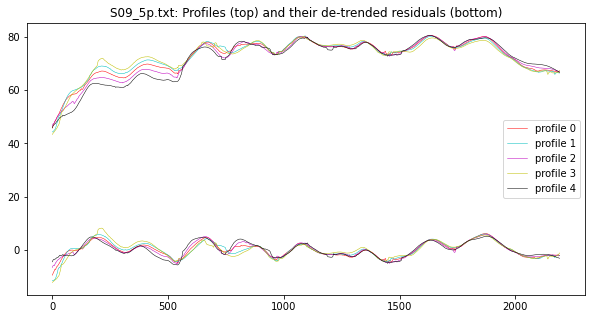

In [4]:
trend = 3 # remove this order of trend from all profiles

# De-trend and store residuals for each profile. 
res_lst, var_last = remove_trend(x_lst, y_lst, filename, deg=trend, plot=True)


### Periodogram settings
- you need to set a probablity (%) of significance that will be plotted with the pgram (siglvl). Pgram values above that line have that much of a probablity to not be by chance  
- Typical use is 0.95 (95% significance) or 0.99
- In the plot you will see a red noise baseline, every pgram value above the is potentially significant but not at the level of the significance line
- You also need to set a window size for smoothing. 1 means no smoothing, 3 means each sample is replaces (smoothed) be the average of itself and the values of its 2 neightbors (=> a window of size 3 is used)
- Be aware that more smoothing tends to lift potentially significant peaks higher, thus making them more significant. I don't know if that's OK or not. I recommend not going beyond a size of 5


In [5]:
# Create periodograms, base lines and significance lines for each residual (of an individual profile)                   
P_lst = []
signif_lst = []
theor_lst = []

smoothwin=1  # moving window for smoothing, 1 means no smoothing (leave at 1 as I don't fully understand the impact of smoothing ...)
siglvl = 0.99 # significance level

# loop over pairs of x (sample distances) and y (residuals), each from a profile
for x, y in zip(x_lst, res_lst):
    P, f = fft1d_pgram(x, y, smoothwin) # returns Periodogram (y-axis) and frequency bins (x-axis)
    P_lst.append(P) # collect P for this residual only as f will always be the same

    fft_theor, fft_signif = fft1d_theor_signif(P,f, x,y, siglvl, smoothwin)
    P_bt_signif = P[P > fft_signif] # number of elements in P that are larger that their corresponding significance
    sig_frac = len(P_bt_signif)/len(P) # fraction of significant Ps
    signif_lst.append(fft_signif)
    theor_lst.append(fft_theor) # maybe these are all the same?



In [6]:
# From the results with the individual profiles (above), average the pgrams, baselines and the significance lines 
P_avg = sum(P_lst)/len(P_lst)
theor_avg = sum(theor_lst) / len(theor_lst)  # red noise baseline
signif_avg = sum(signif_lst) / len(signif_lst)

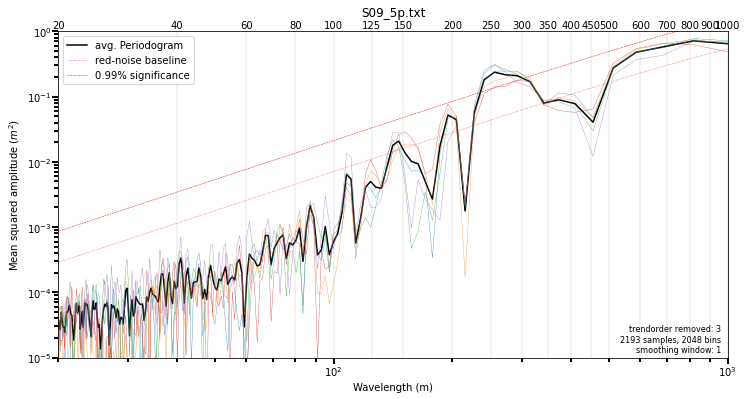

In [14]:
# Plot pgrams

#import seaborn as sns
#sns.set_style("darkgrid") #use a preset template

fig = plt.figure(figsize=(12,6)) # paper is 12 inches wide and 6 inches high.
ax = plt.subplot(label="pgrams") # handle for axis 
plt.title(filename, pad=15, y=None) # None means auto setting for y

# Plot avg. pgram and helper lines
wl = 1/f # wavelength
plt.plot(wl,P_avg, color="Black", lw=1.5,  label='avg. Periodogram') # lw: line width
plt.plot(wl,theor_avg, color="red", lw=0.5, ls=":",  label='red-noise baseline') # dotted
plt.plot(wl,signif_avg, color="red", lw=0.5, ls="--", label=f"{siglvl}% significance") # dashed
ax.legend() # show a legend (default: upper left)

# Plot individual pgrams with rotating (random?) colors
for P in P_lst: 
    plt.plot(wl,P, lw=0.3)

# make x ticks at top and bottom (could be in log10!)
# lists must be custom taylored for the length of the profile!
ticks_top = list(range(20, 101, 20)) + [125] + list(range(150, 500, 50)) + list(range(500, 1001, 100))
for t in ticks_top:
    ax.axvline(t, color='grey', lw=0.2) # plot vertical line that connects top and bottom tick
    trans = ax.get_xaxis_transform()
    plt.text(t, 1.01, # make small gap between labels and the top line
                str(t),
                #color='grey', 
                size=10,
                horizontalalignment='center',
                transform=trans)

# for bottom use same as ticks_top but w/o 125 b/c that freaks out the log 10 based labels
ticks_bot = list(range(20, 101, 20)) + list(range(150, 500, 50)) + list(range(500, 1001, 100)) 
plt.xticks(fontsize=10)
ax.tick_params(which="minor", length=4, width=2)
ax.tick_params( which="major", length=6, width=2, pad=0.5)
ax.set_xticks(ticks_bot)

# text info (lower right corner)
textstr = f"trendorder removed: {trend}\n{len(x)} samples, {len(f)+1} bins\nsmoothing window: {smoothwin}"
ax.text(0.99, 0.01, textstr, transform=ax.transAxes, 
                fontsize=8,
                horizontalalignment='right',
                verticalalignment='bottom')

# configure axis
ax.set_xscale('log')
ax.set_yscale('log')

# limit view to what's relevant (depends heavily on your profiles!)
ax.set_xlim(20, 1000) 
ax.set_ylim(1e-5, 1e-0) # in log10

# Label axis
ax.set_ylabel("Mean squared amplitude ($m^2$)")
ax.set_xlabel("Wavelength (m)")

# save to pdf and show in viewer
plt.savefig("pgram_" + filename + ".pdf")
#plt.show() # show() is not needed with jupyter